Name: Juan Carlos González Martínez		<br> 					
Student ID: 82122300079			<br> 	
Course: Data Science<br> 
Final Assigment<br> 
**Predictive Model of a video game genre using Screenshots**<br> 
**Final Model**

In [9]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from plotly import subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import plot, iplot
import tensorflow.keras.layers as layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
from plotly.offline import iplot, init_notebook_mode
from sklearn.model_selection import train_test_split

In [10]:
#Fixing random seed for reproducibility
SEED = 7
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [11]:
#Assign the training and testing datasets
train_df = pd.read_csv("dataset_train.csv")
test_df  = pd.read_csv("dataset_test.csv")

In [12]:
#Define a dictionary containing the genres of the images
genres = {0: "action", 1: "adventure", 2: "casual", 3: "fps", 4: "horror"}

#Show genre distribution in the training dataset
train_df["Genre"].value_counts() 

Genre
fps          24059
action        7368
adventure     6702
horror        1738
casual         343
Name: count, dtype: int64

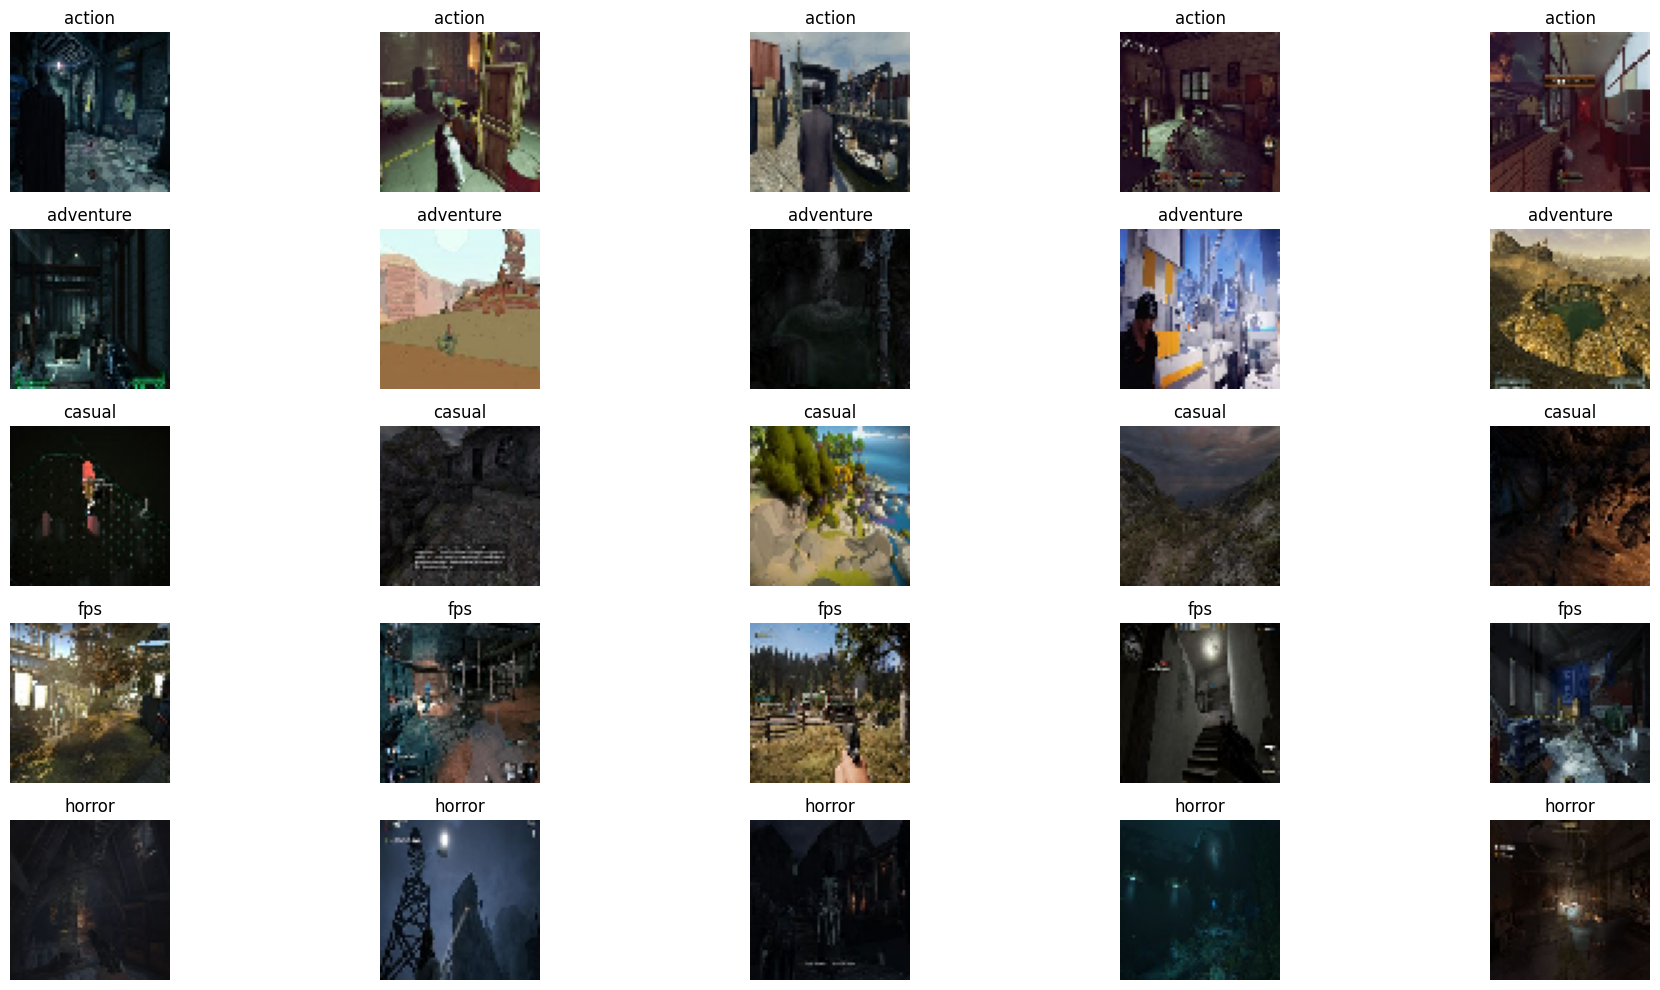

In [13]:
img_size = 64

#Function to load and preprocess images
def load_images(filepaths):
    images = [] 
    for filepath in filepaths:
        img = image.load_img(filepath, target_size=(img_size, img_size)) #Load image and adjust its size to 64x64
        img_array = image.img_to_array(img) #Convert image to Numpy array
        images.append(img_array) #Add image to the images list 
    return np.array(images) #Converts images to a Numpy array and returns it

imgs, genrs = list(), list() 

#Select and show 5 images of each genre as examples
for k in genres.keys():
    examples = train_df[train_df["Genre"].str.lower() == genres[k]].head(5) #Select first 5 images of genre k
    image_paths = examples["ImagePath"].values
    loaded_images = load_images(image_paths) #Load images from their paths
    imgs.extend(loaded_images) #Add loaded images to imgs
    genrs.extend([k] * len(loaded_images)) ##Extend genrs by repeating the genre k for each loaded image
    
#Visualize the images
num_rows = len(genres) 
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2 * num_rows)) #Create a grid of subplots with size (20, 2 * num_rows)

for index, img in enumerate(imgs):
    #index // num_cols and index % num_cols are used to determine the row and column indices of the current subplot
    axs[index // num_cols, index % num_cols].imshow(img.astype(np.uint8), cmap="viridis") #Displays the image in the current subplot
    axs[index // num_cols, index % num_cols].axis('off') #Turns off the axis labels and ticks for better visualization
    axs[index // num_cols, index % num_cols].set_title(genres[genrs[index]]) #Sets the title of the subplot to the index genre based on the genrs

#Adjusts the spacing between subplots and display the grid
fig.tight_layout() 
plt.show()

In [14]:
# Function to preprocess data
def data_preprocessing(df, num_classes):
    label_encoder = LabelEncoder()
    df["Genre"] = label_encoder.fit_transform(df["Genre"])  #Encode Genre column to numerical values
    y = tf.keras.utils.to_categorical(df["Genre"], num_classes) #Genre labels are then one-hot encoded and saved on y
    x = load_images(df["ImagePath"].values) #Images are loaded and saved in x
    x = x / 255 #The pixel values are normalized to scale them to the range [0, 1]
    return x, y

# Apply data preprocessing to training and testing datasets
X_train, y_train = data_preprocessing(train_df, len(genres))
X_test, y_test = data_preprocessing(test_df, len(genres))

In [15]:
#Creation of the model
model = tf.compat.v1.keras.Sequential(name='MerlinVision_CNN')

#Add layers
#2D convolutional layer
model.add(layers.Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu', strides = 2, padding = 'same', input_shape = (img_size, img_size, 3)))
    #Number of filters (kernels) to detect different features in the input set to 32
    #Set the size of the filters to a 5x5 window
    #ReLU allows the model to learn complex patterns in the data with non-linearity
    #The filter moves by 2 pixels at a time
    #A Same padding means the output size is the same as the input size
    #The input will be images of size 28x28 with 3 color channels (RGB)
#2D max pooling layer
model.add(layers.MaxPool2D(pool_size = (2, 2), padding='same'))
    #The Pooling is performed in a 2x2 window
    #Maintain the spatial dimensions after pooling
#Dropout layer
model.add(layers.Dropout(0.2))
    #30% of inputs are dropped to avoid overfitting
#Another 2D convolutional layer
model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', strides = 1))
#Another 2D max pooling layer
model.add(layers.MaxPool2D(pool_size = (2, 2)))
#Another 2D convolutional layer
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', strides = 1, padding = 'same'))
#Flatten layer
model.add(layers.Flatten())
    #To flatten the 3D output to 1D
#Another dropout layer
model.add(layers.Dropout(0.2))
#Fully connected layer
model.add(layers.Dense(256, activation = 'relu'))
    #128 units in the layer
#Another dropout layer
model.add(layers.Dropout(0.3))
#Output layer
model.add(layers.Dense(len(genres), activation = 'softmax')) 
    #len(genres) units for the layer
    #Softmax converts the raw ouput scores into probability distributions over the different genres

#Prints model architerture summary
model.summary()

Model: "MerlinVision_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)    

In [16]:
#Set the number of complete pass throught the training dataset
epochs = 15

#Configure model for training
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Training of the model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs)

Epoch 1/15
1257/1257 [==============================] - 113s 88ms/step - loss: 0.7436 - accuracy: 0.7162 - val_loss: 0.5596 - val_accuracy: 0.7842
Epoch 2/15
1257/1257 [==============================] - 107s 85ms/step - loss: 0.5262 - accuracy: 0.8002 - val_loss: 0.4669 - val_accuracy: 0.8219
Epoch 3/15
1257/1257 [==============================] - 80s 64ms/step - loss: 0.4384 - accuracy: 0.8345 - val_loss: 0.4398 - val_accuracy: 0.8306
Epoch 4/15
1257/1257 [==============================] - 40s 32ms/step - loss: 0.3796 - accuracy: 0.8571 - val_loss: 0.4130 - val_accuracy: 0.8439
Epoch 5/15
1257/1257 [==============================] - 27s 22ms/step - loss: 0.3363 - accuracy: 0.8717 - val_loss: 0.4011 - val_accuracy: 0.8573
Epoch 6/15
1257/1257 [==============================] - 27s 21ms/step - loss: 0.2955 - accuracy: 0.8879 - val_loss: 0.3870 - val_accuracy: 0.8611
Epoch 7/15
1257/1257 [==============================] - 27s 22ms/step - loss: 0.2722 - accuracy: 0.8960 - val_loss: 0.3909

(0.0, 1.0)

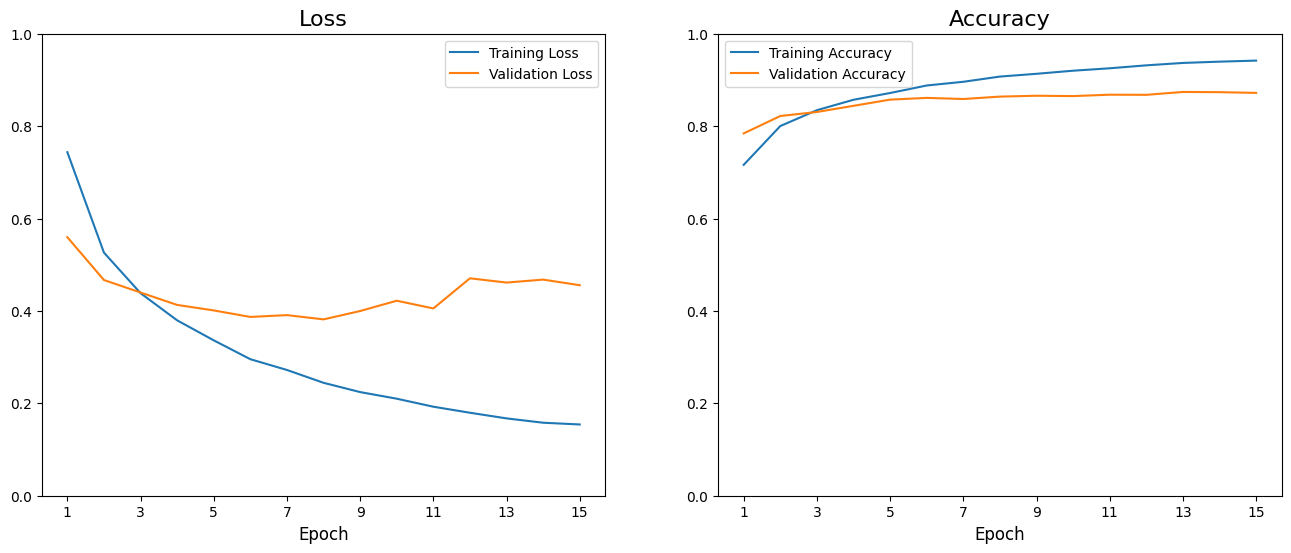

In [17]:
#Create subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    #Creates fig that contains 2 subplots (ax1 and ax2)
    #1 row and 2 columns of subplots
    #The total size of the figure is 16x6
title_fontsize = 16 #Font sizes for titles and axis
axis_fontsize = 12 

#Define training and validation loss over epochs in the subplot ax1
ax1.plot(range(1,epochs + 1), history.history['loss'], label = 'Training Loss') 
    #The x axis values goes from 1 to epochs+1
    #Using history.history['loss'] we access the training loss values stored in history
    #Assign 'Training Loss' as the name of the line in the legend
ax1.plot(range(1,epochs + 1), history.history['val_loss'], label = 'Validation Loss') 
ax1.legend() #Adds a legend to the subplot
ax1.set_xticks(range(1,epochs+1,2)) #Set x axis ticks 
ax1.set_title('Loss', fontsize = title_fontsize) #Set title for the subplot
ax1.set_xlabel('Epoch', fontsize = axis_fontsize) #Set title to the x axis

#Define training and validation accuracy over epochs in the subplot ax2
ax2.plot(range(1,epochs + 1), history.history['accuracy'], label = 'Training Accuracy') 
ax2.plot(range(1,epochs + 1), history.history['val_accuracy'], label = 'Validation Accuracy') 
ax2.legend() 
ax2.set_xticks(range(1,epochs+1,2)) 
ax2.set_title('Accuracy', fontsize = title_fontsize) 
ax2.set_xlabel('Epoch', fontsize = axis_fontsize) 

#Set the y axis range from 0 to 1 in bothsubplots (Delete this part for better visualization)
ax1.set_ylim([0, 1]) 
ax2.set_ylim([0, 1])

In [18]:
#The model predicts the output of the training dataset
y_pred = model.predict(X_test)

#Retrieves the index of the max value along the axis 1 for each row in the true and predicted genres
y_test_genres = np.argmax(y_test, axis = 1)
y_pred_genres = np.argmax(y_pred, axis = 1)

539/539 [==============================] - 4s 6ms/step


In [19]:
#The indices of y_test_genres and y_pred_genres are mapped to their corresponding names
y_test_genres = [list(genres.values())[i] for i in y_test_genres]
y_pred_genres = [list(genres.values())[i] for i in y_pred_genres]

<Axes: >

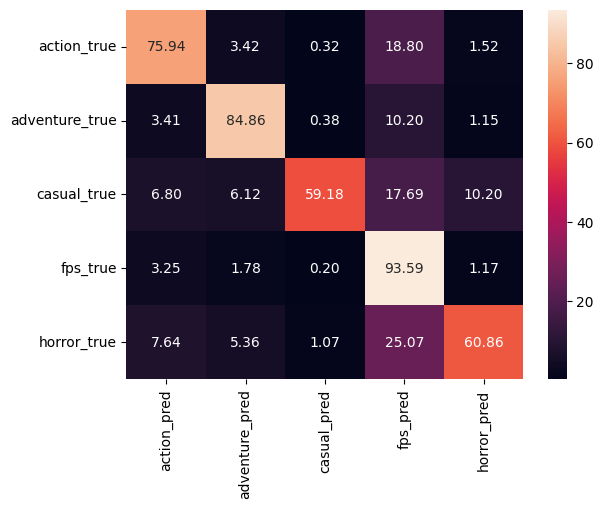

In [20]:
#Generation of the Confusion Matrix 

conf_mat = confusion_matrix(y_test_genres, y_pred_genres, labels = list(genres.values()), normalize = 'true') * 100
    #Uses the true and predicted genre labels to calculate the Confusion Matrix
    #The genre parameter specifies the list of unique genre names
    #By multiplying each element in the matrix by 100, the values are converted to percentages

#Creating Pnadas DataFrame
df = pd.DataFrame(conf_mat, columns = [genre + '_pred' for genre in list(genres.values())], index = [genre + '_true' for genre in list(genres.values())]).copy()
    #The columns represent the predicted genres (Adds "_pred" to each genre name in the columns)
    #The rows represent the true genres (Adds "_true" to each genre name in the rows)
    #".copy()" creates a copy of te DataFrame instead of a reference to it

#Heatmap visualization of the DataFrame
sns.heatmap(df, annot = True, fmt = ".2f")
    #Setting annot to True adds text annotations to the cells
    #The annotations will have floating point number with two decimals format

In [21]:
#Classification report

#Create a list of class names to be used as labels
target_names = ["Class {} ({}) :".format(i, list(genres.values())[i]) for i in range(len(genres))]

print(classification_report(y_test_genres, y_pred_genres, target_names = target_names))

                       precision    recall  f1-score   support

   Class 0 (action) :       0.83      0.76      0.79      3159
Class 1 (adventure) :       0.88      0.85      0.86      2873
   Class 2 (casual) :       0.64      0.59      0.61       147
      Class 3 (fps) :       0.90      0.94      0.92     10312
   Class 4 (horror) :       0.68      0.61      0.64       746

             accuracy                           0.87     17237
            macro avg       0.78      0.75      0.76     17237
         weighted avg       0.87      0.87      0.87     17237

